# HW 2 - Разложение матриц градиентным методом

Цель задания: В ходе реализации [разложения Таккера](https://proceedings.neurips.cc/paper/2018/file/45a766fa266ea2ebeb6680fa139d2a3d-Paper.pdf) градиентным методом освоить pyTorch и реализовать подходы оптимизации параметров модели (в отсутствии готовых решений).

[Более-менее внятное описание алгоритма канонического разложения](https://www.alexejgossmann.com/tensor_decomposition_tucker/)

In [1]:
!pip install -U tensorly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 198 kB 5.3 MB/s 
     |████████████████████████████████| 154 kB 60.1 MB/s 


In [2]:
import torch
import tensorly

torch.manual_seed(0)

## 1 Реализуйте метод для восстановления тензора по разложению

In [3]:
# Функция, восстанавливающая тензор по ядру и матрицам
def repair_tensor(G_, U) -> torch.Tensor:
  # data - восстановленный тензор из матриц и ядра
  # U - список матриц
  # G_ - ядро разложения
  data = G_
  for i, u in enumerate(U):
    curr_shape = data.shape
    indices = list(range(data.ndim))
    element = indices.pop(i)
    my_unfold = data.permute([element] + indices[::-1]).reshape((data.shape[i], -1))
    un_folded_data = u @ my_unfold
    shape = [curr_shape[k] if k != i else u.shape[0] for k in range(len(curr_shape))]

    indices = list(range(len(shape)))
    element = indices.pop(i)

    unfolded_indices = [element] + indices[::-1]
    original_shape = [shape[i] for i in unfolded_indices]
    un_folded_data = un_folded_data.reshape(original_shape)
    folded_indices = list(range(len(shape)-1, 0, -1))
    folded_indices.insert(i, 0)
    data = un_folded_data.permute(folded_indices)

  return data

In [4]:
import inspect

In [8]:
inspect.getsource(torch.mean)

TypeError: ignored

In [ ]:
def MSE(target, predict):
    return torch.mean((target-predict)**2)

## 2 Создайте 3х мерный тензор
Размер тензора не меньше 100 по каждой из размерностей.

Заполните случайными целыми числами в диапазоне от 0 до 9.

Примечание: разложение будет корректно работать со случайным тензором, только если изначально создавать случайные ядро и матрицы, а потом по ним формировать тензор. Работайте с типом *torch.Tensor.double*.

In [ ]:
# Создадим тензор: размер тензора и r задаётся
def get_tensor(size=(100,200,150), r=(10, 20, 30)):
  # data - тензор с заданной размерностью
  # U - список матриц
  # G - ядро разложения
  G = torch.rand(r) * 9
  U = [
    torch.rand(size=(dim, r_dim))
    for r_dim, dim in zip(r, size)
  ]
    
  data = repair_tensor(G, U)
  return data, U, G

Сгенерируйте тензор и добавьте к нему случайный шум с размерностью *1e-2*

In [ ]:
data, U, G = get_tensor(r=(10, 20, 30))
data.shape, [u.shape for u in U], G.shape

(torch.Size([100, 200, 150]),
 [torch.Size([100, 10]), torch.Size([200, 20]), torch.Size([150, 30])],
 torch.Size([10, 20, 30]))

In [ ]:
data = data + 1e-2 * torch.normal(mean=torch.zeros_like(data)).to()

Вопрос:
Почему задание не имеет смысла для полностью случайного тензора и зачем добавлять шум? *не отвечать нельзя*

Ответ:

## 3 Сделайте разложение библиотечным методом
Пакет можете брать любой

In [ ]:
import tensorly.decomposition

In [ ]:
core, factors = tensorly.decomposition.tucker(data.numpy(), (10, 20, 30))
core = torch.tensor(core)
factors = [torch.tensor(factor.copy()) for factor in factors]

data_rep = repair_tensor(core, factors)

Не забудьте померить ошибку разложения по метрике MSE

In [ ]:
torch.mean((data_rep - data)**2), torch.mean((core - G)**2)

(tensor(2.7658), tensor(6.3287e+09))

# HW 2 - Разложение матриц градиентным методом. Part 2

## 4 Реализуйте разложение градиентным методом

### 4.1 Реализуйте *optimizer*
Можно взять из исходников *PyTorch* и отнаследоваться от *torch.optim.optimizer*.
Используйте квадратичный *Loss*.

In [ ]:
import math
from torch.optim.optimizer import Optimizer
import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [ ]:
class Opt(Optimizer):
    def __init__(self, params, lr=1e-2):
        defaults = dict(lr=lr)
        super(Opt, self).__init__(params, defaults)

    def step(self):
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad
                p.data -= group['lr'] * grad

### 4.2 Реализуйте цикл оптимизации параметров

In [ ]:
TENSOR_SIZE = (100, 200, 300)
RANKS = (10, 20, 30)

DATA_SIZE = 5
NUM_EPOCHS = 5000

In [ ]:
# Generating target tensor
data = []
for i in range(DATA_SIZE):
    tensor, _, _ = get_tensor(TENSOR_SIZE, RANKS)
    data += [tensor + 1e-2 * torch.normal(mean=torch.zeros_like(tensor)).to()]

In [ ]:
def learning_schedule(t):
    return t0 / (t + t1)

t0, t1 = 5, 100  # learning schedule hyperparameters

loss_over_data = []
start_time = time.time()
lrs = []
lr = 2*1e-3
for tensor in data:
    loss_history = []
    
    # Generating initial approximation
    kernel_approx = torch.rand(RANKS, requires_grad=True)
    factors_approx = [
        torch.rand(size=(dim, r_dim), requires_grad=True)
        for r_dim, dim in zip(RANKS, TENSOR_SIZE)
    ]
    optim = Opt(params=[kernel_approx] + factors_approx, lr = lr)
    
    for epoch in tqdm(range(NUM_EPOCHS)):
        optim.zero_grad()

        tensor_approx = repair_tensor(kernel_approx, factors_approx)
        loss = MSE(tensor, tensor_approx)
        loss.backward()

        loss_history += [loss]

        optim.step()
        lr = learning_schedule(epoch)
        lrs.append(optim.param_groups[0]["lr"])
    
    loss_over_data += [loss_history]
end_time = time.time()
grad_mean_time = (end_time-start_time) / DATA_SIZE

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
data = torch.randint(low=0, high=10, size=TENSOR_SIZE, dtype=torch.double, device='cuda')

In [ ]:
core = torch.randint(low=0, high=2, size=RANKS, dtype=torch.double, requires_grad=True, device='cuda')
factors = [torch.randint(low=0, high=2, size=(TENSOR_SIZE[i], RANKS[i]), dtype=torch.double, requires_grad=True, device='cuda') for i in range(len(TENSOR_SIZE))]

loss_values = []
lrs = []

lr = 2*1e-3

opt = Opt([core] + factors, lr=lr)

lmbda = lambda epoch: 0.65 ** 1
scheduler = torch.optim.lr_scheduler.MultiplicativeLR(opt,lr_lambda=lmbda)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max = 1, eta_min = 0)

for i in tqdm(range(10000)):
    opt.zero_grad()

    loss = MSE(repair_tensor(core, factors), data)
    loss_values.append(loss.item())

    loss.backward()
    opt.step()
    lrs.append(opt.param_groups[0]["lr"])
    # scheduler.step()

  0%|          | 0/10000 [00:00<?, ?it/s]

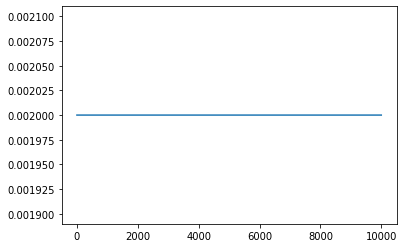

In [ ]:
plt.plot(lrs)
# plt.plot(lrs)

(0.0, 10.0)

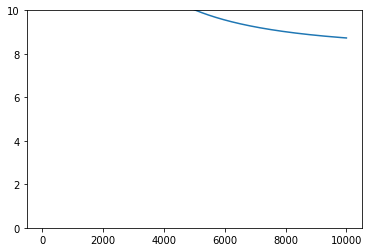

In [ ]:
# loss_values = [value.detach().to() for value in loss_over_data[0]]
plt.plot(loss_values)
loss_values[-1]
plt.ylim([0, 10])

## 5 Приведите сравнение скорости работы и ошибки восстановления методом из пакета и реализованного градиентного
Сравнение может считаться ± объективным с размером выборки от 10.

In [ ]:
grad_mean_loss = torch.mean(torch.tensor([loss_over_data[i][-1] for i in range(DATA_SIZE)]))

In [ ]:
print("Средняя ошибка MSE по всем данным:")
print(f"- градиентная оптимизация {float(grad_mean_loss):.6}", )

Средняя ошибка MSE по всем данным:
- библиотечное решение   3.394
- градиентная оптимизация 214.093


In [ ]:
print("Среднее время работы (сек):")
print(f"- градиентная оптимизация {grad_mean_time:.5}", )

Среднее время работы (сек):
- библиотечное решение   1.563
- градиентная оптимизация 139.58
